In [2]:
# Chapter 7 - Combining Different Models for Ensemble Learning
from IPython.display import Image
%matplotlib inline

In [3]:
# 1：Learning with ensembles

from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1 - error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [4]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [5]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

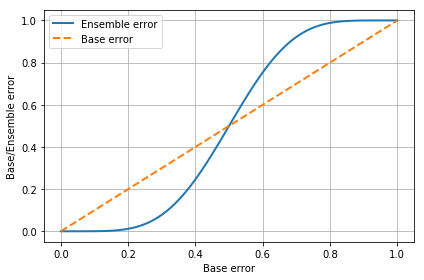

In [6]:
import matplotlib.pyplot as plt

plt.plot(error_range,
         ens_errors,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range,
         error_range,
         linestyle='--',
         label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

In [7]:
# Implementing a simple majority vote classifier

import numpy as np

np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
np.argmax(p)

[0.58 0.42]


0

In [29]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [30]:
# Combining different algorithms for classification with majority vote

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [31]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], 
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
         % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [36]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
         % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


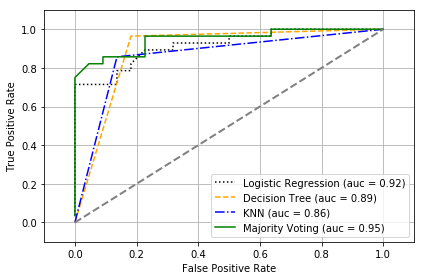

In [39]:
# Evaluating and tuning the ensemble classifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyle = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyle):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    frp, trp, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=frp, y=trp)
    plt.plot(frp, trp, color=clr, linestyle=ls, label='%s (auc = %0.2f)' 
             % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.show()

In [40]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


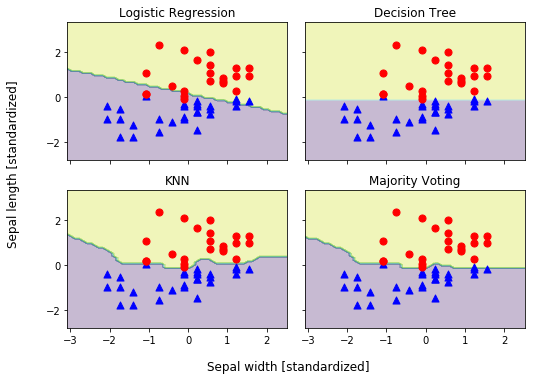

In [44]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), 
                         all_clf, clf_labels):
    
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                  X_train_std[y_train == 0, 1],
                                  c = 'blue',
                                  marker = '^',
                                  s = 50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                  X_train_std[y_train == 1, 1],
                                  c = 'red',
                                  marker = 'o',
                                  s = 50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5,
         s='Sepal length [standardized]',
         ha='center', va='center', fontsize=12, rotation=90)
plt.tight_layout()
plt.show()

In [45]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

In [51]:

from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)
cv_keys = ('mean_test_score', 'std_test_score','params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
            %  (grid.cv_results_[cv_keys[0]][r], 
                grid.cv_results_[cv_keys[1]][r] / 2.0, 
                grid.cv_results_[cv_keys[2]][r]))

0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [52]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 1.00


In [53]:
grid.best_estimator_.classifiers

[Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=2,
            weights=

In [54]:
mv_clf = grid.best_estimator_

In [55]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None)

In [56]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None)

In [ ]:
# Bagging -- Building an ensemble of classifiers from bootstrap samples